# Clasificacion de Residuos solidos usando ConvNeXT
**Nombre:** Brayan Simpon Polo Orellana

**GitHub:** https://github.com/bspoloo/SIS421-022025/tree/main/Laboratorios/Laboratorio%201/ConvNeXT

En este laboratorio sobre una Red neuronal convolucional para la clasificación de imágenes mediante Trasnfer learning, aplicando fine tunning y freezeando la ultima capa de un modelo preentrenado.

# Que es ConvNeXT

ConvNeXt es una arquitectura de visión por computadora (CNN) desarrollada por Facebook AI en 2022.
La idea fue modernizar las CNNs clásicas (ResNet) con mejoras inspiradas en los Transformers (ViT), pero manteniendo solo convoluciones.

¿Qué pasa si actualizamos ResNet con las técnicas modernas de Transformers, pero sin usar auto-atención?

ConvNeXT es una arquitectura de red neuronal convolucional moderna, inspirada en los Transformers, pero usando convoluciones. Su objetivo es cerrar la brecha de desempeño entre CNNs y Transformers en visión, manteniendo la eficiencia computacional de las CNNs. ConvNeXT Tiny es la versión más pequeña, adecuada para datasets medianos o pruebas rápidas.

**Detalles Clave de ConvNeXT**

- Depthwise Convolutions (k=7x7): Reemplazan self-attention de ViT, capturando contexto global eficientemente.

- Inversión de Bottleneck: Primero expande canales (x4) y luego reduce, contrario a ResNet.

- LayerNorm (LN): Usado en lugar de BatchNorm, crucial para estabilidad.

- GELU vs ReLU: Mejor rendimiento en tareas complejas.

- Residual Connections: Como en ResNet, facilitan el entrenamiento profundo.

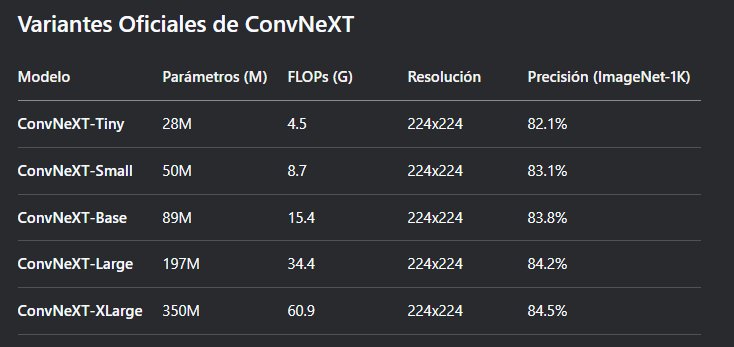

**¿Por qué ConvNeXT es poderoso?**

- Eficiencia: Más rápido que ViT en entrenamiento (sin self-attention costosa).
- Precisión: Supera a ResNet y Swin Transformers en ImageNet.
- Simplicidad: Solo usa convoluciones, evitando complejidad de Transformers.

**Principios clave:**

- Usa bloques de convolución 2D modernos.
- Reemplaza algunas operaciones clásicas de CNN por LayerNorm, Depthwise Convolutions, y residual connections inspiradas en Transformers.
- Mantiene la eficiencia para entrenar en GPU estándar.

<img src="./ConvNeXT/ConvNeXT architecture.png" alt="ConvNeXT Architecture" width="20%" />

### 1. Input Image (224x224x3)
Entrada: Una imagen RGB de tamaño 224x224 píxeles con 3 canales (rojo, verde, azul).

### 2. Stem (Conv 4x4, stride 4)
Objetivo: Reemplaza el patch embedding de los Vision Transformers (ViT) con una convolución tradicional.

**Operación:**

- Aplica una convolución 4x4 con stride=4 (deslizamiento de 4 píxeles).
- Salida: Reduce la resolución espacial y extrae características iniciales.
- Tamaño de salida: 56x56x96 (96 canales de características).

### 3. Etapas (Stages 1-4)
Cada etapa reduce la resolución espacial y aumenta los canales, similar a ResNet pero con bloques modernizados.

**Stage 1 (56x56x96 → 28x28x192)**
Bloque ConvNeXT:

- **Depthwise Convolution (Conv 7x7, grupos=canales):** Captura información espacial como en los ViT.

- **LayerNorm (LN):** Normaliza por canal (mejor que BatchNorm para batches pequeños).

- **Conv 1x1 (Expansión):** Aumenta canales temporalmente (ej: de 96 a 384).

- **GELU Activation:** Función de activación no lineal. (Gaussian Error Linear Unit)

- **Conv 1x1 (Reducción):** Vuelve a los canales originales (192 en Stage 1).

- **Conexión Residual:** Suma la entrada original (como en ResNet).

- **Downsample:** Reducción de resolución a 28x28 (usando LayerNorm + Conv 2x2, stride=2).

**Stage 2 (28x28x192 → 14x14x384)**
- Misma estructura, pero con más canales (384). La resolución se reduce a 14x14.

**Stage 3 (14x14x384 → 7x7x768)**
- Aumenta canales a 768 y reduce resolución a 7x7.

**Stage 4 (7x7x768 → 768)**
- Última etapa sin reducción espacial. Las características se mantienen en 768 canales.

### 4. Global Average Pooling (GAP)
Reduce cada canal 7x7 a un solo valor promedio.

Entrada: 7x7x768 → Salida: 1x1x768.

### 5. LayerNorm
Normalización final para estabilizar los valores antes de la clasificación.

### 6. Fully Connected (Linear Layer)
Capa lineal que mapea los 768 canales a num_classes (ej: 1000 clases en ImageNet).

**Salida:** Logits (puntuaciones para cada clase).

## Fine tunning con ConvNeXT

En lugar de una inicialización aleatoria, inicializamos la red con una red preentrenada, como la que se entrena con el conjunto de datos imagenet 1000. El resto del entrenamiento se desarrolla de forma normal.

In [13]:
# ======================
# 🔹 PyTorch principal
# ======================
import torch                      # Librería base de PyTorch (tensores, operaciones en CPU/GPU)
import torch.nn as nn             # Construcción de redes neuronales (capas, pérdidas, activaciones)
import torch.optim as optim       # Optimizadores (SGD, Adam, RMSprop, etc.)
from torch.optim import lr_scheduler  # Planificadores de tasa de aprendizaje
import torch.backends.cudnn as cudnn  # Optimizaciones para GPU con cuDNN (NVIDIA)

# ======================
# 🔹 NumPy
# ======================
import numpy as np                # Cálculo científico y manejo de arrays

# ======================
# 🔹 TorchVision
# ======================
import torchvision                 # Librería de visión por computadora para PyTorch
from torchvision import datasets, models, transforms
# datasets  → carga datasets comunes (ImageNet, CIFAR, MNIST…)
# models    → modelos preentrenados (ResNet, ConvNeXt, EfficientNet, etc.)
# transforms → transformaciones de imágenes (resize, crop, normalización)

# ======================
# 🔹 Visualización
# ======================
import matplotlib.pyplot as plt   # Graficar curvas, imágenes y resultados

# ======================
# 🔹 Utilidades generales
# ======================
import time                       # Medir tiempos (entrenamiento, inferencia, etc.)
import os                         # Manejo de archivos y rutas
from PIL import Image             # Procesamiento de imágenes (abrir, convertir, manipular)
from tempfile import TemporaryDirectory  # Crear carpetas temporales (para datasets/resultados)

# ======================
# 🔹 Configuraciones extra
# ======================
cudnn.benchmark = True   # Acelera el entrenamiento en GPU si las entradas tienen tamaño fijo
plt.ion()               # Activa modo interactivo en matplotlib (los gráficos no bloquean el script)


## Carga de datos

Usaremos los paquetes torchvision y torch.utils.data para cargar los datos.

El problema que resolveremos es entrenar un modelo para clasificar:

- Llantas
- Baldes de plastico
- Filtros de aceite de auto
- Tapas de baldes
- Conservas de cafe

Contamos con unas 35.805 imágenes de entrenamiento para cada una de ellas. tomaremos el 20% de validacion de cada clase. No

Este conjunto de datos es un subconjunto muy pequeño de imagenet.

In [14]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = r"C:\Users\Admin\Ciencias\Residuos solidos\data"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


## Visualizacion de imagenes

Visualicemos algunas imágenes de entrenamiento para comprender las ampliaciones de datos.

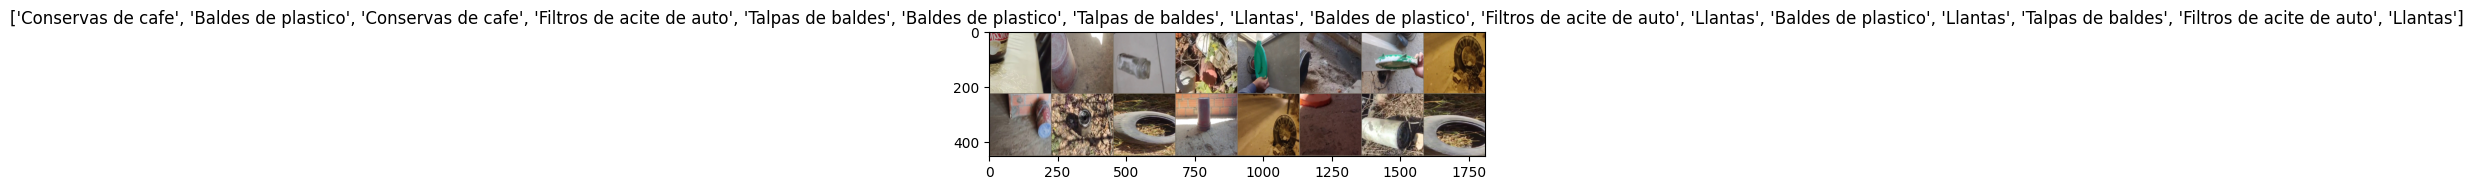

In [15]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Entrenamiento del modelo

Ahora, escribamos una función general para entrenar un modelo. A continuación, ilustraremos:

- Programación de la tasa de aprendizaje
- Guardar el mejor modelo

A continuación, el parámetro "scheduler" es un objeto "scheduler" de LR de **torch.optim.lr_scheduler**.

In [16]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # Guardado en entrenamiento (cada época)
                if phase == 'train':
                    torch.save(
                        model.state_dict(),
                        os.path.join(tempdir, f'model_train_epoch_{epoch}.pt')
                    )

                # Guardado en validación si mejora la accuracy
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model


## Visualizando las predicciones del modelo
Funcion generica para mostrar predicciones para unas pocas imagenes


In [17]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [24]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

In [18]:
import torch
import torch.nn as nn
from torchvision import models

# Limpiar caché de CUDA antes de empezar
torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Verificar memoria disponible
if torch.cuda.is_available():
    print(f"Memoria GPU total: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    print(f"Memoria GPU reservada: {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB")
    print(f"Memoria GPU asignada: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")

Usando dispositivo: cuda
Memoria GPU total: 6.00 GB
Memoria GPU reservada: 0.52 GB
Memoria GPU asignada: 0.34 GB


## Finetuning al ConvNeXT

Cargamos un modelo previamente entrenado y restablezca la capa final completamente conectada.

Primero imprimimos las clases disponibles:

In [19]:
all_labels = []
for _, labels in dataloaders['train']:
    all_labels.extend(labels.tolist())
print("Clases únicas:", set(all_labels))

Clases únicas: {0, 1, 2, 3, 4}


In [20]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar ConvNeXt Tiny preentrenado
model_ft = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1)

# Ajustar la capa final (classifier) al número de clases
num_ftrs = model_ft.classifier[2].in_features
model_ft.classifier[2] = nn.Linear(num_ftrs, 5)  # 5 clases

# Mover el modelo al dispositivo
model_ft = model_ft.to(device)

# Definir criterio y optimizador
criterion = nn.CrossEntropyLoss()
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


## Entrenamiento y evaluacion

Debería tardar entre 15 y 25 minutos en la CPU. Sin embargo, en la GPU, tarda menos de un minuto.

In [11]:
import gc
import torch

# Antes de entrenar
torch.cuda.empty_cache()
gc.collect()

# Verificar estado de memoria
if torch.cuda.is_available():
    print(f"Memoria GPU antes del entrenamiento:")
    print(f"Asignada: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
    print(f"Reservada: {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB")

Memoria GPU antes del entrenamiento:
Asignada: 0.10 GB
Reservada: 0.12 GB


In [21]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 0.5516 Acc: 0.7800
val Loss: 0.0503 Acc: 0.9778

Epoch 1/9
----------
train Loss: 0.1142 Acc: 0.9611
val Loss: 0.0341 Acc: 0.9866

Epoch 2/9
----------
train Loss: 0.0649 Acc: 0.9769
val Loss: 0.0055 Acc: 0.9982

Epoch 3/9
----------
train Loss: 0.0542 Acc: 0.9814
val Loss: 0.0015 Acc: 0.9997

Epoch 4/9
----------
train Loss: 0.0446 Acc: 0.9847
val Loss: 0.0023 Acc: 0.9994

Epoch 5/9
----------
train Loss: 0.0350 Acc: 0.9877
val Loss: 0.0033 Acc: 0.9993

Epoch 6/9
----------
train Loss: 0.0328 Acc: 0.9889
val Loss: 0.0014 Acc: 0.9999

Epoch 7/9
----------
train Loss: 0.0157 Acc: 0.9949
val Loss: 0.0004 Acc: 0.9999

Epoch 8/9
----------
train Loss: 0.0112 Acc: 0.9962
val Loss: 0.0003 Acc: 1.0000

Epoch 9/9
----------
train Loss: 0.0106 Acc: 0.9962
val Loss: 0.0002 Acc: 0.9999

Training complete in 72m 51s
Best val Acc: 1.000000


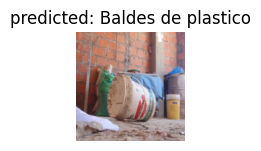

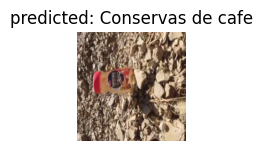

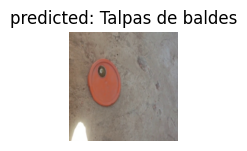

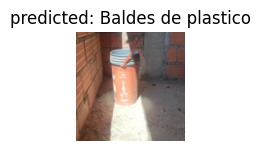

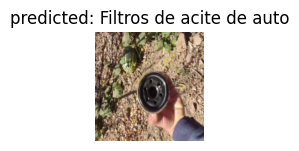

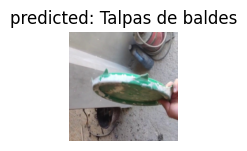

In [22]:
visualize_model(model_ft)

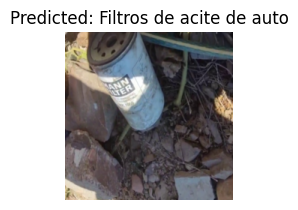

In [28]:
visualize_model_predictions(
    model_ft,
    img_path=r"C:\Users\Admin\Ciencias\Residuos solidos\data\val\Filtros de acite de auto\xtp9gisxge6gqy70.jpg"
)

plt.ioff()
plt.show()

## ConvNet as fixed feature extractor
Aquí, necesitamos congelar toda la red excepto la capa final. Debemos configurar requires_grad = False para congelar los parámetros y evitar que los gradientes se calculen en backward().

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.models as models

# Cargar ConvNeXt preentrenado en ImageNet
model_conv = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1)

# Congelar todas las capas
for param in model_conv.parameters():
    param.requires_grad = False

# Reemplazar la última capa (classifier) por una nueva con tus clases
num_ftrs = model_conv.classifier[2].in_features
model_conv.classifier[2] = nn.Linear(num_ftrs, 5)  # 5 clases

model_conv = model_conv.to(device)

# Definir loss
criterion = nn.CrossEntropyLoss()

# Optimizar solo los parámetros de la última capa
optimizer_conv = optim.SGD(model_conv.classifier[2].parameters(), lr=0.001, momentum=0.9)

# Scheduler (reduce LR cada 7 épocas por 0.1)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


## Entrenamiento y evalucaion

In [8]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

Epoch 0/24
----------
train Loss: 0.1462 Acc: 0.9655
val Loss: 0.0147 Acc: 0.9996

Epoch 1/24
----------
train Loss: 0.0609 Acc: 0.9835
val Loss: 0.0080 Acc: 0.9999

Epoch 2/24
----------
train Loss: 0.0492 Acc: 0.9858
val Loss: 0.0054 Acc: 0.9997

Epoch 3/24
----------
train Loss: 0.0447 Acc: 0.9872
val Loss: 0.0043 Acc: 0.9999

Epoch 4/24
----------
train Loss: 0.0415 Acc: 0.9878
val Loss: 0.0037 Acc: 0.9997

Epoch 5/24
----------
train Loss: 0.0379 Acc: 0.9890
val Loss: 0.0030 Acc: 0.9999

Epoch 6/24
----------
train Loss: 0.0362 Acc: 0.9892
val Loss: 0.0027 Acc: 0.9997

Epoch 7/24
----------
train Loss: 0.0327 Acc: 0.9904
val Loss: 0.0027 Acc: 0.9997

Epoch 8/24
----------
train Loss: 0.0355 Acc: 0.9889
val Loss: 0.0026 Acc: 0.9997

Epoch 9/24
----------
train Loss: 0.0336 Acc: 0.9901
val Loss: 0.0026 Acc: 0.9997

Epoch 10/24
----------
train Loss: 0.0338 Acc: 0.9898
val Loss: 0.0026 Acc: 0.9997

Epoch 11/24
----------
train Loss: 0.0330 Acc: 0.9900
val Loss: 0.0026 Acc: 0.9997

Ep

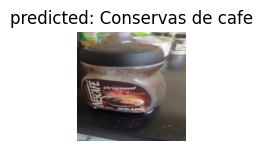

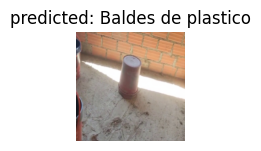

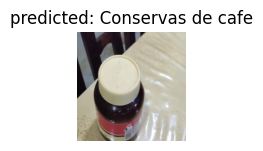

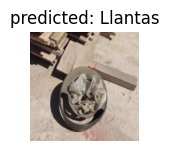

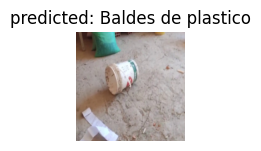

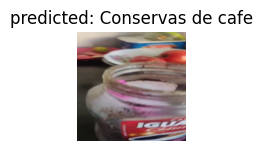

In [11]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [27]:
visualize_model_predictions(
    model_conv,
    img_path=r"C:\Users\Admin\Ciencias\Residuos solidos\data\val\Filtros de acite de auto\xtp9gisxge6gqy70.jpg"
)

plt.ioff()
plt.show()

NameError: name 'model_conv' is not defined